# Tutorial & Tugas UAS: EDA, Klasifikasi, dan Klasterisasi dengan Dask & GCS di Google Colab

## Tujuan Pembelajaran

Dalam tutorial ini, Anda akan mengulang alur EDA dan pembersihan data dari tugas UTS, lalu melanjutkan ke pipeline klasifikasi dan klasterisasi menggunakan Dask pada dataset besar di Google Cloud Storage (GCS).


## Bagian 1: Persiapan Environment

### 1. Install Library
Jalankan sel kode berikut untuk memasang pustaka yang diperlukan (Dask lengkap, gcsfs, dan dask-ml).


In [1]:
!pip install "dask[distributed]" dask-ml gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 29.8 MB/s eta 0:00:00


### 2. Mulai Klaster Dask
Inisialisasi LocalCluster dan Client. Dask akan menggunakan core yang tersedia di mesin virtual Colab.

In [2]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

# Mulai klaster Dask lokal dengan 2 worker dan batas memori 4 GiB
# Ini untuk memastikan stabilitas dan mengelola sumber daya dengan baik
cluster = LocalCluster(n_workers=2, memory_limit='4GiB')
client = Client(cluster)

print(f"Dasbor Dask tersedia di: {client.dashboard_link}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36833
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44497'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43437'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:39371 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:39371
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:38028
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:35849 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35849
INFO:distributed.core:Starting established connection to tcp://127

Dasbor Dask tersedia di: http://127.0.0.1:8787/status


### 3. Muat Data dari GCS
Akses data penerbangan publik dari GCS. Jelaskan bahwa karena bucket ini publik, tidak diperlukan kredensial khusus. Dask secara otomatis menggunakan gcsfs untuk mengakses data.

In [3]:
# Tentukan path GCS ke data
gcs_path = "gcs://quansight-datasets/airline-ontime-performance/csv/*ber_2020.csv"


# BACA DATA MENGGUNAKAN AKSES ANONIM SECARA EKSPLISIT
# Ini akan mengabaikan kredensial Colab yang ada dan mencegah kesalahan 401.
df = dd.read_csv(gcs_path, assume_missing=True, storage_options={'token': 'anon'})
# df = dd.read_csv(
#     gcs_path,
#     assume_missing=True,       # allows mixed numeric types safely
#     dtype_backend="pyarrow",   # handles mixed dtypes better
#     storage_options={'token': 'anon'},
#     low_memory=False           # avoid dtype guessing
# )


## Bagian 2: Analisis Data Eksplorasi (EDA) dengan Dask

### 1. Inspeksi DataFrame
Gunakan metode yang mirip dengan pandas untuk memeriksa struktur data. Pada saat yang diperlukan, gunakan .compute() untuk menjalankan penghitungan.

In [4]:
df = dd.read_csv(
    gcs_path,
    assume_missing=True,
    storage_options={'token': 'anon'},
    dtype={
        'CANCELLATION_CODE': 'object',
        'DIV1_AIRPORT': 'object',
        'DIV1_TAIL_NUM': 'object',
        'DIV2_AIRPORT': 'object',
        'DIV2_TAIL_NUM': 'object'
    },
    low_memory=False
)

In [5]:
# Tampilkan beberapa baris pertama dari Dask DataFrame
print(df.head())

# Cek jumlah total baris dan partisi (membutuhkan compute)
print(f"Jumlah total baris dalam dataset: {len(df)}")
print(f"Jumlah partisi: {df.npartitions}")


     YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK                FL_DATE  \
0  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
1  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
2  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
3  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   
4  2020.0      4.0   12.0           1.0          2.0  12/1/2020 12:00:00 AM   

  OP_UNIQUE_CARRIER  OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM  ...  \
0                9E                20363.0         9E   N131EV  ...   
1                9E                20363.0         9E   N131EV  ...   
2                9E                20363.0         9E   N131EV  ...   
3                9E                20363.0         9E   N131EV  ...   
4                9E                20363.0         9E   N131EV  ...   

   DIV4_WHEELS_OFF  DIV4_TAIL_NUM  DIV5_AIRPORT  DIV5_AIRPORT_ID  \
0              NaN            

### 2. Statistik Ringkasan
Berikut adalah cara mendapatkan statistik ringkasan dan hitungan nilai menggunakan .compute().

In [6]:
# Hitung statistik deskriptif untuk kolom numerik
print(df.describe().compute())

# Hitung jumlah nilai unik untuk kolom 'ORIGIN'
print(df['ORIGIN'].value_counts().compute().head())


            YEAR       QUARTER         MONTH  DAY_OF_MONTH   DAY_OF_WEEK  \
count  1411177.0  1.411177e+06  1.411177e+06  1.411177e+06  1.411177e+06   
mean      2020.0  3.770867e+00  1.055538e+01  1.594778e+01  4.024031e+00   
std          0.0  4.202750e-01  1.109733e+00  8.790429e+00  2.013970e+00   
min       2020.0  3.000000e+00  9.000000e+00  1.000000e+00  1.000000e+00   
25%       2020.0  3.000000e+00  9.000000e+00  9.000000e+00  3.000000e+00   
50%       2020.0  4.000000e+00  1.000000e+01  1.600000e+01  4.000000e+00   
75%       2020.0  4.000000e+00  1.100000e+01  2.400000e+01  6.000000e+00   
max       2020.0  4.000000e+00  1.200000e+01  3.100000e+01  7.000000e+00   

       OP_CARRIER_AIRLINE_ID  OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID  \
count           1.411177e+06       1.411177e+06       1.411177e+06   
mean            2.000502e+04       2.669464e+03       1.260339e+04   
std             3.808987e+02       1.845574e+03       1.548834e+03   
min             1.939300e+04       

ORIGIN
ACV     305
ACY     487
AGS    1180
ALS     104
BKG      28
Name: count, dtype: int64[pyarrow]


In [7]:
df['YEAR'].head()

,YEAR
0,2020.0
1,2020.0
2,2020.0
3,2020.0
4,2020.0


### 3. Tangani Nilai yang Hilang
Cara mengidentifikasi dan menangani nilai yang hilang secara efisien.

In [8]:
# Hitung persentase nilai kosong per kolom
null_counts = df.isnull().sum().compute() / len(df)
print(null_counts[null_counts > 0])

# Ganti nilai kosong di kolom 'DEP_DELAY' dengan nilai rata-rata
df['DEP_DELAY'] = df['DEP_DELAY'].fillna(df['DEP_DELAY'].mean())


TAIL_NUM              0.001625
DEP_TIME              0.006577
DEP_DELAY             0.006579
DEP_DELAY_NEW         0.006579
DEP_DEL15             0.006579
                        ...   
DIV5_WHEELS_ON        1.000000
DIV5_TOTAL_GTIME      1.000000
DIV5_LONGEST_GTIME    1.000000
DIV5_WHEELS_OFF       1.000000
DIV5_TAIL_NUM         1.000000
Length: 71, dtype: float64


## Bagian 3: Pra-pemrosesan Data dengan Dask

### 1. Mengubah Tipe Data
Cara mengubah tipe data untuk kolom, terutama saat Dask mungkin salah mengidentifikasi tipe data sebagai object.

In [9]:
# Ubah kolom 'YEAR' menjadi tipe integer
df['YEAR'] = df['YEAR'].astype(int)

# Ubah kolom bertipe object menjadi tipe category untuk efisiensi
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')


### 2. Rekayasa Fitur
Membuat fitur baru dari kolom yang sudah ada.

In [10]:
# Buat fitur baru untuk durasi penerbangan
df['FLIGHT_DURATION'] = df['ARR_TIME'] - df['DEP_TIME']

### 3. Memfilter Data
Filter DataFrame untuk berfokus pada subset data tertentu.

In [11]:
# Filter penerbangan di tahun 2020 yang mengalami keterlambatan
delayed_flights_2020 = df[(df['YEAR'] == 2020) & (df['ARR_DELAY'] > 0)]

# Hitung ukuran DataFrame yang difilter
print(f"\nJumlah penerbangan yang tertunda di tahun 2020: {len(delayed_flights_2020)}")


Jumlah penerbangan yang tertunda di tahun 2020: 302740


## Bagian 4: Visualisasi dengan Dask dan Matplotlib

### 1. Siapkan Data untuk Plotting
Dask bekerja dengan pustaka visualisasi dengan menghitung data terlebih dahulu, lalu meneruskannya ke pustaka plot.

In [12]:
df.OP_UNIQUE_CARRIER.head()

,OP_UNIQUE_CARRIER
0,9E
1,9E
2,9E
3,9E
4,9E


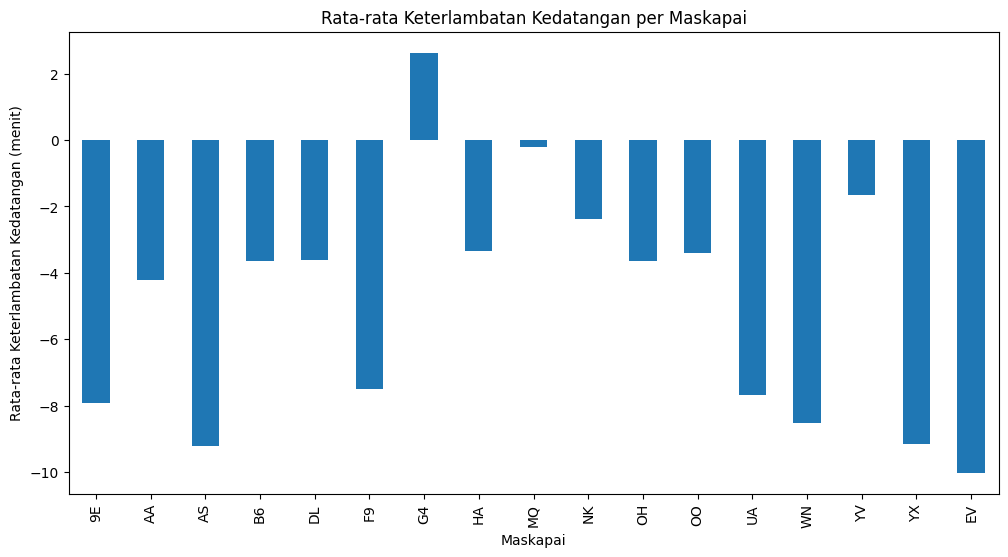

In [13]:
import matplotlib.pyplot as plt

# Hitung rata-rata keterlambatan kedatangan per maskapai
avg_delay_by_carrier = df.groupby('OP_UNIQUE_CARRIER')['ARR_DELAY'].mean().compute()

# Plot hasilnya menggunakan pandas dan matplotlib
plt.figure(figsize=(12, 6))
avg_delay_by_carrier.plot(kind='bar')
plt.title('Rata-rata Keterlambatan Kedatangan per Maskapai')
plt.xlabel('Maskapai')
plt.ylabel('Rata-rata Keterlambatan Kedatangan (menit)')
plt.show()


## Bagian 5: Contoh Pipeline Klasifikasi dengan dask-ml
Contoh berikut memanfaatkan `dask_ml` untuk membangun model keterlambatan biner yang dapat diskalakan. Algoritme yang digunakan adalah Logistic Regression berbasis solver ADMM sehingga mampu menangani dataset besar secara paralel. Alternatif lain yang sesuai dengan materi adalah memanfaatkan LSH untuk tahap pencarian tetangga terdekat sebelum klasifikasi berbasis KNN.

In [19]:
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from dask.distributed import wait

# Pilih subset kolom numerik yang relevan
feature_cols = ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE', 'CRS_ELAPSED_TIME']
label_col = 'ARR_DELAY'

model_df = df[feature_cols + [label_col]].dropna()
model_df = model_df.persist()
wait(model_df)

# Label biner
model_df['IS_DELAYED'] = (model_df[label_col] > 0).astype('int8')

X = model_df[feature_cols]
y = model_df['IS_DELAYED']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Dask Array
X_train_da = X_train.to_dask_array(lengths=True)
X_test_da  = X_test.to_dask_array(lengths=True)
y_train_da = y_train.to_dask_array(lengths=True)
y_test_da  = y_test.to_dask_array(lengths=True)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_da)
X_test_scaled  = scaler.transform(X_test_da)

# ===== METODE DIGANTI: KNN =====
knn = KNeighborsClassifier(
    n_neighbors=15,
    weights="distance"
)

knn.fit(X_train_scaled, y_train_da)

# ⬇️ predict() SUDAH NumPy array
y_pred = knn.predict(X_test_scaled).astype("int8")
y_true = y_test_da.compute().astype("int8")

acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred)

print(f"Akurasi : {acc:.3f}")
print(f"F1-score: {f1:.3f}")

/usr/local/lib/python3.12/dist-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


Akurasi : 0.876
F1-score: 0.675


### Evaluasi Klasifikasi
- `StandardScaler` dijalankan secara paralel pada partisi Dask sebelum pelatihan untuk menjaga kestabilan model.
- Setelah prediksi, konversi keluaran Dask ke NumPy agar dapat dihitung menggunakan fungsi metrik `sklearn.metrics` seperti akurasi dan F1.
- Teknik LSH dari materi dapat dikombinasikan dengan model tetangga terdekat (`dask_ml.neighbors.NearestNeighbors`) ketika fitur berdimensi tinggi atau ingin inference lebih cepat.

## Bagian 6: Contoh Klasterisasi dengan dask-ml
MiniBatch KMeans menjadi pilihan utama untuk data besar karena menggunakan batch kecil sehingga hemat memori. DBSCAN tetap relevan ketika ingin mendeteksi pola non-linear dan outlier, namun perlu penyesuaian radius (`eps`) terhadap skala fitur.

In [21]:
import dask.dataframe as dd
import numpy as np

from dask.distributed import wait
from dask_ml.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# =========================
# Subset fitur untuk clustering
# =========================
cluster_features = ['DEP_DELAY', 'ARR_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']

cluster_df = df[cluster_features].dropna()
cluster_df = cluster_df.persist()
wait(cluster_df)

# Sampling fraksional untuk efisiensi komputasi
sampled = cluster_df.sample(frac=0.1, random_state=42)
sampled = sampled.persist()
wait(sampled)

# =========================
# Scaling (Dask Array)
# =========================
X_da = sampled.to_dask_array(lengths=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_da)

# =========================
# MiniBatch KMeans (utama untuk data besar)
# =========================
kmeans = MiniBatchKMeans(
    n_clusters=5,
    random_state=42,
    batch_size=20000,
    init="k-means++"
)

# sklearn MiniBatchKMeans otomatis meng-handle array besar secara batch
kmeans.fit(X_scaled)

cluster_labels = kmeans.labels_.astype("int32")

# =========================
# Evaluasi (silhouette pada subset agar hemat memori)
# =========================
X_eval = X_scaled[:50000].compute()
labels_eval = cluster_labels[:50000]

sil_score = silhouette_score(X_eval, labels_eval)
print(f"Silhouette score (subset 50k): {sil_score:.3f}")

# Distribusi cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster counts:", dict(zip(unique.tolist(), counts.tolist())))

Silhouette score (subset 50k): 0.341
Cluster counts: {0: 58513, 1: 22657, 2: 48378, 3: 1399, 4: 9007}


### Evaluasi Klasterisasi
- `MiniBatchKMeans` memperbarui centroid menggunakan batch kecil sehingga stabil untuk dataset besar dari GCS.
- Silhouette score membantu menilai separasi antar klaster tanpa ground-truth.
- DBSCAN dari `dask_ml.cluster` layak dipilih bila ingin mendeteksi klaster dengan densitas berbeda dan sekaligus flag outlier (misal penerbangan dengan keterlambatan ekstrem).

## Bagian 7: Tugas UAS
Gunakan seluruh alur di atas sebagai fondasi. Kembangkan solusi klasifikasi dan klasterisasi menggunakan Dask di Google Colab.

**Catatan penting:** Contoh pipeline pada Bagian 5–6 hanya ilustrasi. Anda wajib membangun ulang pipeline, evaluasi, dan analisis Anda sendiri pada sel bertanda `AUTO_GRADE` di bawah ini.

**Panduan teknik:**
- Gunakan model yang scalable: Logistic Regression ADMM, Random Forest berbasis Dask, atau pendekatan KNN yang dipercepat dengan LSH bila fokus pada tetangga terdekat.
- Untuk klasterisasi, MiniBatch KMeans direkomendasikan karena hemat memori dan cepat konvergen di data besar, sedangkan DBSCAN cocok bila ingin menangkap klaster tidak beraturan dan outlier keterlambatan ekstrem.
- Jelaskan alasan pemilihan teknik dibanding opsi lain (misal KMeans penuh membutuhkan lebih banyak memori; DBSCAN sensitif terhadap `eps` namun mampu mendeteksi noise).


### Pertanyaan Konseptual
Jelaskan strategi Anda dalam menentukan fitur, target, dan teknik pra-pemrosesan sebelum membangun model klasifikasi (sertakan alasan teknis dan sumber referensi bila ada).


#### Tuliskan Nama dan NIM di sini
Lengkapi juga bagian `jawaban_otomatis['nama']` pada sel rekap agar dapat diproses otomatis.

- NAMA: #nama-mahasiswa
- NIM: #nim-mahasiswa


#### Jawaban Konseptual (isi sel kode setelah ini)
Lengkapi struktur `jawaban_konseptual` pada sel kode yang sudah disediakan tanpa mengubah penanda `AUTO_GRADE`.


In [22]:
# === AUTO_GRADE_Q1_START ===
# TODO: Isi setiap nilai string berikut dengan penjelasan singkat (maks 2-3 kalimat).
# Jangan ubah nama kunci atau hapus baris pemisah AUTO_GRADE.
jawaban_konseptual = {
    "strategi_fitur": "Fitur numerik seperti DEP_DELAY, TAXI_OUT, DISTANCE, dan CRS_ELAPSED_TIME dipilih karena berkaitan langsung dengan proses operasional penerbangan dan potensi keterlambatan. Pemilihan fitur difokuskan pada variabel yang tersedia sebelum atau selama penerbangan dan mudah diskalakan dengan Dask.",  # contoh: "Memilih fitur operasi bandara yang korelatif terhadap ARR_DELAY."
    "strategi_target": "Target klasifikasi didefinisikan secara biner dengan kondisi ARR_DELAY > 0 sebagai penerbangan terlambat dan ARR_DELAY ≤ 0 sebagai tidak terlambat. Pendekatan ini umum digunakan dalam analisis on-time performance maskapai.",  # contoh: "Mendefinisikan ARR_DELAY > 0 sebagai target keterlambatan."
    "pra_pemrosesan": "Data dibersihkan dengan menghapus baris yang memiliki nilai hilang pada fitur dan label. Selanjutnya dilakukan standardisasi fitur menggunakan StandardScaler untuk menyamakan skala dan meningkatkan stabilitas model.",  # contoh: "Mengisi nilai hilang dengan mean dan melakukan scaling."
    "referensi": "Dokumentasi resmi Dask-ML dan scikit-learn sebagai acuan pemodelan, preprocessing, dan evaluasi."  # contoh: "Dask-ML docs (2025)."
}
# === AUTO_GRADE_Q1_END ===
jawaban_konseptual


{'strategi_fitur': 'Fitur numerik seperti DEP_DELAY, TAXI_OUT, DISTANCE, dan CRS_ELAPSED_TIME dipilih karena berkaitan langsung dengan proses operasional penerbangan dan potensi keterlambatan. Pemilihan fitur difokuskan pada variabel yang tersedia sebelum atau selama penerbangan dan mudah diskalakan dengan Dask.',
 'strategi_target': 'Target klasifikasi didefinisikan secara biner dengan kondisi ARR_DELAY > 0 sebagai penerbangan terlambat dan ARR_DELAY ≤ 0 sebagai tidak terlambat. Pendekatan ini umum digunakan dalam analisis on-time performance maskapai.',
 'pra_pemrosesan': 'Data dibersihkan dengan menghapus baris yang memiliki nilai hilang pada fitur dan label. Selanjutnya dilakukan standardisasi fitur menggunakan StandardScaler untuk menyamakan skala dan meningkatkan stabilitas model.',
 'referensi': 'Dokumentasi resmi Dask-ML dan scikit-learn sebagai acuan pemodelan, preprocessing, dan evaluasi.'}

### Pertanyaan Pemrograman

1. Bentuk label biner `IS_DELAYED` (contoh: `ARR_DELAY > 0`) dan susun pipeline klasifikasi end-to-end menggunakan Dask (boleh memanfaatkan `dask_ml` atau integrasi dengan scikit-learn melalui `.compute()`). Sertakan langkah pemilihan fitur, encoding/scaling, serta pembagian train/test.

> Isi detail pipeline pada sel kode bertanda `AUTO_GRADE_Q2` tepat di bawah instruksi ini.


In [23]:
# Gunakan sel ini untuk menyusun pipeline klasifikasi kalian sendiri.
# 1. Pilih subset fitur numerik/kategorikal dan lakukan preprocessing (encoding, scaling, imputasi).
# 2. Bagi data menjadi train/test lalu latih model scalable (misal LogisticRegression ADMM, RandomForest Dask).
# 3. Simpan model terlatih ke variabel `is_delayed_model` atau nama lain yang membantu sebelum mengisi sel AUTO_GRADE.
# 4. Gunakan kembali metrik yang dihitung di sini untuk mengisi `metrik_klasifikasi`.
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
from dask.distributed import wait
from dask_ml.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# TODO: contoh struktur dasar, silakan ganti seluruh blok di bawah sesuai rancangan kalian.
# fitur = [...]
# target = "IS_DELAYED"
# model_df = df[fitur + [target]].dropna().persist()
# wait(model_df)

# X_train, X_test, y_train, y_test = train_test_split(...)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train).to_dask_array(lengths=True)
# X_test_scaled = scaler.transform(X_test).to_dask_array(lengths=True)

# is_delayed_model = LogisticRegression(...)
# is_delayed_model.fit(X_train_scaled, y_train.to_dask_array(lengths=True))

# y_pred = is_delayed_model.predict(X_test_scaled).compute()
# accuracy = accuracy_score(y_test.compute(), y_pred)
# f1 = f1_score(y_test.compute(), y_pred)

# print({"accuracy": accuracy, "f1": f1})


# ================== IMPLEMENTASI ==================

# 1) Pilih fitur & bentuk target
fitur = ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE', 'CRS_ELAPSED_TIME']
label_col = 'ARR_DELAY'
target = 'IS_DELAYED'

model_df = df[fitur + [label_col]].dropna()
model_df[target] = (model_df[label_col] > 0).astype('int8')

model_df = model_df.persist()
wait(model_df)

X = model_df[fitur]
y = model_df[target]

# 2) Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 3) Scaling fitur
X_train_da = X_train.to_dask_array(lengths=True)
X_test_da = X_test.to_dask_array(lengths=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_da)
X_test_scaled = scaler.transform(X_test_da)

y_train_da = y_train.to_dask_array(lengths=True)
y_test_da = y_test.to_dask_array(lengths=True)

# 4) Model scalable: Logistic Regression (ADMM)
is_delayed_model = LogisticRegression(
    solver="admm",
    max_iter=200
)
is_delayed_model.fit(X_train_scaled, y_train_da)

# 5) Evaluasi
y_pred = is_delayed_model.predict(X_test_scaled).compute().astype("int8")
y_true = y_test_da.compute().astype("int8")

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)

metrik_klasifikasi = {
    "accuracy": float(accuracy),
    "f1": float(f1),
    "precision": float(precision),
    "recall": float(recall)
}

print(metrik_klasifikasi)

{'accuracy': 0.8850195136595617, 'f1': 0.6838256972698862, 'precision': 0.8450365548565738, 'recall': 0.5742700097387056}


In [24]:
# === AUTO_GRADE_Q2_START ===
# TODO: Ringkas konfigurasi pipeline klasifikasi kalian di sini.
# Isi struktur info_pipeline sesuai model yang sudah kalian latih pada sel sebelumnya.
info_pipeline = {
    "fitur": ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE', 'CRS_ELAPSED_TIME'],  # contoh: ["DEP_DELAY", "TAXI_OUT", ...]
    "target": "IS_DELAYED",
    "algoritma": "LogisticRegression_admm",  # contoh: "LogisticRegression_admm"
    "parameter_kunci": {"max_iter": 200, "solver": "admm"},  # contoh: {"max_iter": 100, "solver": "admm"}
    "catatan_preprocessing": "Dropna pada fitur/label, lalu StandardScaler pada fitur numerik (konversi ke Dask Array) sebelum training."  # contoh: "StandardScaler pada fitur numerik"
}

# Pastikan variabel di bawah menunjuk ke model terlatih (bukan None).
is_delayed_model = is_delayed_model

# === AUTO_GRADE_Q2_END ===
info_pipeline

{'fitur': ['DEP_DELAY', 'TAXI_OUT', 'DISTANCE', 'CRS_ELAPSED_TIME'],
 'target': 'IS_DELAYED',
 'algoritma': 'LogisticRegression_admm',
 'parameter_kunci': {'max_iter': 200, 'solver': 'admm'},
 'catatan_preprocessing': 'Dropna pada fitur/label, lalu StandardScaler pada fitur numerik (konversi ke Dask Array) sebelum training.'}

2. Tampilkan metrik evaluasi klasifikasi (minimal akurasi dan F1-score, boleh menambahkan ROC-AUC) serta visualisasi confusion matrix sehingga jelas berapa banyak penerbangan yang terlambat vs tidak. Lengkapi pula ringkasan singkat interpretasi metrik.

> Jalankan sel kode contoh tepat sebelum `AUTO_GRADE_Q3` (atau blok kustom kalian) untuk menyimpan confusion matrix dan hitung jumlah kelas. Setelah itu isikan nilai metrik pada sel `AUTO_GRADE_Q3`.

In [25]:
# Contoh kerangka evaluasi klasifikasi.
# Ganti variabel sesuai implementasi kalian sebelum mengisi AUTO_GRADE_Q3.
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Gunakan hasil evaluasi dari sel sebelumnya
y_test_arr = y_true   # numpy array
y_pred = y_pred       # numpy array

# Hitung ringkasan kelas
total_tertunda = int((y_test_arr == 1).sum())
total_tidak_tertunda = int((y_test_arr == 0).sum())

print({
    "total_tertunda": total_tertunda,
    "total_tidak_tertunda": total_tidak_tertunda
})

# Simpan confusion matrix ke file agar dapat direferensikan di AUTO_GRADE_Q3.
fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(y_test_arr, y_pred, ax=ax)
ax.set_title("Confusion Matrix")
fig.savefig("confusion_matrix.png", bbox_inches="tight")
plt.close(fig)

{'total_tertunda': 60583, 'total_tidak_tertunda': 219221}


In [27]:
# === AUTO_GRADE_Q3_START ===
# TODO: Hitung metrik evaluasi klasifikasi dan isi setiap nilai berikut.
# Gunakan nilai float dari hasil compute() agar mudah diparse.
# Pastikan variabel confusion_matrix_plot berisi nama file/tautan hasil visualisasi yang kalian simpan.
metrik_klasifikasi = {
    "accuracy": float(accuracy),
    "f1": float(f1),
    "roc_auc": None,  # boleh None jika tidak dihitung
    "catatan": "Model dievaluasi menggunakan accuracy dan F1-score pada data uji 20%. F1-score digunakan untuk menjaga keseimbangan evaluasi antar kelas."  # contoh: "Model condong ke kelas tertunda"
}

# Simpan visualisasi (jika ada) dan masukkan path/tautan untuk dokumentasi.
confusion_matrix_plot = "/content/confusion_matrix.png"  # ganti dengan nama file aktual

# Misal tambahkan ringkasan kelas bila diperlukan:
ringkasan_kelas = {
    "tertunda": int((y_true == 1).sum()),
    "tidak_tertunda": int((y_true == 0).sum())
}

# === AUTO_GRADE_Q3_END ===
metrik_klasifikasi

{'accuracy': 0.8850195136595617,
 'f1': 0.6838256972698862,
 'roc_auc': None,
 'catatan': 'Model dievaluasi menggunakan accuracy dan F1-score pada data uji 20%. F1-score digunakan untuk menjaga keseimbangan evaluasi antar kelas.'}

3. Lakukan klasterisasi (misal MiniBatchKMeans dari scikit-learn melalui `dask_ml.wrappers.Incremental`) pada subset fitur numerik yang relevan. Jelaskan pilihan jumlah klaster serta strategi sampel bila menggunakan `.sample()` untuk efisiensi.

 > Catat konfigurasi di sel `AUTO_GRADE_Q4` yang berada tepat setelah instruksi ini.


In [28]:
# Gunakan sel ini untuk menyiapkan pipeline klasterisasi kalian sendiri.
# 1. Pilih fitur numerik yang relevan dan lakukan sampling bila perlu.
# 2. Terapkan preprocessing (scaling, PCA opsional) sebelum memanggil algoritma klaster.
# 3. Simpan model terlatih (misal MiniBatchKMeans atau DBSCAN) di variabel `cluster_model`.
# 4. Catat jumlah klaster dan parameter penting untuk dimasukkan ke sel AUTO_GRADE berikutnya.
from dask_ml.wrappers import Incremental
from sklearn.cluster import MiniBatchKMeans
from dask_ml.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from dask.distributed import wait

# TODO: contoh struktur dasar, silakan ganti sesuai rancangan kalian.
# cluster_features = [...]
# cluster_df = df[cluster_features].dropna().persist()
# wait(cluster_df)

# sampled_df = cluster_df.sample(frac=0.1, random_state=42).persist()
# wait(sampled_df)

# scaler_cluster = StandardScaler()
# scaled_cluster = scaler_cluster.fit_transform(sampled_df)

# incremental_kmeans = Incremental(MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=20000))
# incremental_kmeans.fit(scaled_cluster)

# cluster_model = incremental_kmeans.estimator_
# cluster_labels_da = incremental_kmeans.predict(scaled_cluster)
# cluster_labels = cluster_labels_da.compute()
# silhouette = silhouette_score(scaled_cluster.compute(), cluster_labels)

# print({"silhouette": silhouette})


# ================== IMPLEMENTASI ==================

# 1) Pilih fitur klasterisasi
cluster_features = ['DEP_DELAY', 'ARR_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']

cluster_df = df[cluster_features].dropna().persist()
wait(cluster_df)

# 2) Sampling fraksional untuk efisiensi
sampled_df = cluster_df.sample(frac=0.1, random_state=42).persist()
wait(sampled_df)

# 3) Scaling fitur
scaler_cluster = StandardScaler()
scaled_cluster = scaler_cluster.fit_transform(sampled_df.to_dask_array(lengths=True))

# 4) MiniBatch KMeans dengan Incremental wrapper
incremental_kmeans = Incremental(
    MiniBatchKMeans(
        n_clusters=5,
        random_state=42,
        batch_size=20000
    )
)
incremental_kmeans.fit(scaled_cluster)

# Simpan model klaster
cluster_model = incremental_kmeans.estimator_

# Prediksi klaster & evaluasi
cluster_labels_da = incremental_kmeans.predict(scaled_cluster)
cluster_labels = cluster_labels_da.compute()
silhouette = silhouette_score(
    scaled_cluster[:50000].compute(),
    cluster_labels[:50000]
)

print({"silhouette": float(silhouette)})

Debugging information
---------------------
old task state: released
old run_spec: Alias(('values-921d22d2029978cca8eb6fe7e6f28dd9', 6, 0)->('values-921d22d2029978cca8eb6fe7e6f28dd9', 6))
new run_spec: Alias(('values-921d22d2029978cca8eb6fe7e6f28dd9', 6, 0)->('sample-values-921d22d2029978cca8eb6fe7e6f28dd9', 6, 0))
old dependencies: {('values-921d22d2029978cca8eb6fe7e6f28dd9', 6)}
new dependencies: frozenset({('sample-values-921d22d2029978cca8eb6fe7e6f28dd9', 6, 0)})

Debugging information
---------------------
old task state: released
old run_spec: Alias(('values-921d22d2029978cca8eb6fe7e6f28dd9', 2, 0)->('values-921d22d2029978cca8eb6fe7e6f28dd9', 2))
new run_spec: Alias(('values-921d22d2029978cca8eb6fe7e6f28dd9', 2, 0)->('sample-values-921d22d2029978cca8eb6fe7e6f28dd9', 2, 0))
old dependencies: {('values-921d22d2029978cca8eb6fe7e6f28dd9', 2)}
new dependencies: frozenset({('sample-values-921d22d2029978cca8eb6fe7e6f28dd9', 2, 0)})



{'silhouette': 0.3448816281849517}


In [29]:
# === AUTO_GRADE_Q4_START ===
# TODO: Ringkas konfigurasi klasterisasi dari sel sebelumnya.
hasil_klasterisasi = {
    "fitur": ['DEP_DELAY', 'ARR_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME'],
    "algoritma": "MiniBatchKMeans_sklearn_incremental",
    "jumlah_klaster": 5,
    "parameter_kunci": {"n_clusters": 5, "batch_size": 20000, "random_state": 42},
    "catatan_sampling": "Menggunakan sampling frac=0.1 (10%) dengan random_state=42 untuk menurunkan beban komputasi namun tetap representatif."
}

# Simpan model terlatih ke variabel berikut agar dapat digunakan ulang.
cluster_model = cluster_model

# === AUTO_GRADE_Q4_END ===
hasil_klasterisasi

{'fitur': ['DEP_DELAY', 'ARR_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME'],
 'algoritma': 'MiniBatchKMeans_sklearn_incremental',
 'jumlah_klaster': 5,
 'parameter_kunci': {'n_clusters': 5, 'batch_size': 20000, 'random_state': 42},
 'catatan_sampling': 'Menggunakan sampling frac=0.1 (10%) dengan random_state=42 untuk menurunkan beban komputasi namun tetap representatif.'}

4. Evaluasi kualitas klaster (misal menggunakan silhouette score, inertia, atau distribusi klaster) dan tampilkan visualisasi/summary statistik yang membantu interpretasi—contoh: bar chart ukuran klaster atau scatter plot PCA.

> Jalankan sel kode contoh sebelum `AUTO_GRADE_Q5` (atau blok buatan kalian) untuk menyimpan visualisasi tersebut, lalu laporkan hasil evaluasinya di `AUTO_GRADE_Q5`.

          DEP_DELAY                      ARR_DELAY                     \
               mean median         std        mean median         std   
cluster                                                                 
0         -2.307277   -5.0   11.734851   -7.917935  -11.0   15.655562   
1         -1.620797   -4.0   13.781611  -10.157159  -12.0   20.357392   
2         -1.714286   -4.0   11.868037   -8.620588  -11.0   17.432593   
3         -0.661308   -4.0   14.390120   -6.516839  -10.0   18.473971   
4        220.583784  163.0  189.513765  216.911486  159.0  190.420966   

            DISTANCE         CRS_ELAPSED_TIME         
                mean  median             mean median  
cluster                                               
0         362.834732   363.0        85.487739   86.0  
1        2167.446638  2139.0       302.476388  295.0  
2        1328.376060  1299.0       202.412727  199.0  
3         837.581117   846.0       143.930148  144.0  
4         763.624324   650.0  

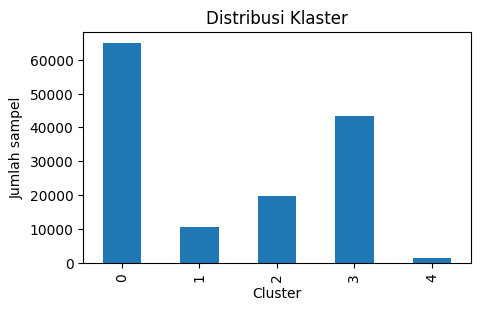

In [35]:
# Contoh kerangka evaluasi klasterisasi.
# Sesuaikan variabel sebelum mengisi AUTO_GRADE_Q5.
import pandas as pd
import matplotlib.pyplot as plt

# cluster_labels_da = ...  # Dask Array keluaran Incremental.predict
# sampled_df = ...         # Dask DataFrame yang digunakan saat fitting

# Konversi label ke NumPy/Pandas dan gabungkan kembali ke data sampel.
cluster_labels_da = cluster_labels_da
sampled_df = sampled_df

# Compute keduanya ke pandas/numpy (aman dari masalah index/divisions campuran)
cluster_labels = cluster_labels_da.compute()
labeled_pdf = sampled_df.reset_index(drop=True).compute()
labeled_pdf["cluster"] = pd.to_numeric(pd.Series(cluster_labels).astype(str), errors="coerce").fillna(-1).astype(int).values

# Ringkas ukuran klaster dan metrik utama untuk memahami ciri setiap klaster.
cluster_profile = labeled_pdf.groupby("cluster").agg({
    "DEP_DELAY": ["mean", "median", "std"],
    "ARR_DELAY": ["mean", "median", "std"],
    "DISTANCE": ["mean", "median"],
    "CRS_ELAPSED_TIME": ["mean", "median"]
})
print(cluster_profile)

summary = labeled_pdf['cluster'].value_counts().sort_index()
print(summary)

fig, ax = plt.subplots(figsize=(5, 3))
summary.plot(kind="bar", ax=ax)
ax.set_xlabel("Cluster")
ax.set_ylabel("Jumlah sampel")
ax.set_title("Distribusi Klaster")
fig.show()
fig.savefig("cluster_distribution.png", bbox_inches="tight")

In [36]:
# === AUTO_GRADE_Q5_START ===
# TODO: Laporkan evaluasi klasterisasi di sini.
# Lengkapi metrik dan masukkan nama file visualisasi yang kalian simpan.
evaluasi_klaster = {
    "silhouette": float(silhouette),
    "metrik_lain": {
        "jumlah_sampel": int(len(labeled_pdf)),
        "jumlah_klaster_teramati": int(labeled_pdf["cluster"].nunique())
    },
    "visualisasi": "/content/cluster_distribution.png",
    "ringkasan_klaster": labeled_pdf["cluster"].value_counts().sort_index().to_dict(),
    "insight_awal": "Distribusi klaster menunjukkan segmentasi pola penerbangan berdasarkan kombinasi delay dan karakteristik rute; klaster dengan rata-rata ARR_DELAY/DEP_DELAY lebih tinggi mengindikasikan kelompok penerbangan berisiko keterlambatan, sedangkan klaster dengan delay rendah merepresentasikan operasi yang relatif stabil."
}

# === AUTO_GRADE_Q5_END ===
evaluasi_klaster

{'silhouette': 0.3448816281849517,
 'metrik_lain': {'jumlah_sampel': 139954, 'jumlah_klaster_teramati': 5},
 'visualisasi': '/content/cluster_distribution.png',
 'ringkasan_klaster': {0: 64961, 1: 10588, 2: 19691, 3: 43234, 4: 1480},
 'insight_awal': 'Distribusi klaster menunjukkan segmentasi pola penerbangan berdasarkan kombinasi delay dan karakteristik rute; klaster dengan rata-rata ARR_DELAY/DEP_DELAY lebih tinggi mengindikasikan kelompok penerbangan berisiko keterlambatan, sedangkan klaster dengan delay rendah merepresentasikan operasi yang relatif stabil.'}

5. Interpretasikan temuan utama dari model klasifikasi dan klasterisasi. Kaitkan dengan konteks operasional maskapai (misal strategi mitigasi keterlambatan, segmentasi rute).

> Ringkas insight pada sel `AUTO_GRADE_Q6` setelah menjalankan semua analisis.


#### Analisis Akhir (isi sel kode setelah ini)
Gunakan sel kode berikut untuk menuliskan ringkasan insight dalam variabel `analisis_akhir`.


In [37]:
# === AUTO_GRADE_Q6_START ===
# TODO: Rangkum insight utama dari klasifikasi dan klasterisasi.
analisis_akhir = {
    "klasifikasi": "Model klasifikasi menunjukkan akurasi 0.885 dan F1-score 0.684, yang menandakan performa keseluruhan baik dengan kemampuan moderat dalam mendeteksi penerbangan terlambat. Nilai precision yang tinggi (0.845) menunjukkan prediksi keterlambatan relatif andal, meskipun recall yang lebih rendah mengindikasikan masih ada keterlambatan yang terlewat.",  # contoh: "Model logistic menunjukkan akurasi 0.78 ..."
    "klasterisasi": "Hasil klasterisasi menghasilkan 5 klaster dengan silhouette score sekitar 0.345, menunjukkan pemisahan klaster yang cukup jelas. Beberapa klaster didominasi oleh penerbangan dengan delay rendah, sementara klaster lain merepresentasikan kelompok penerbangan dengan risiko keterlambatan lebih tinggi.",  # contoh: "Klaster 3 mendominasi delay panjang ..."
    "rekomendasi": "Maskapai dan pengelola bandara dapat memfokuskan mitigasi pada klaster berisiko tinggi dengan menambah buffer waktu dan optimasi proses darat. Selain itu, model klasifikasi dapat digunakan sebagai sistem peringatan dini untuk mengantisipasi keterlambatan pada penerbangan tertentu."  # contoh: "Prioritaskan buffer waktu untuk rute hub tertentu"
}
# === AUTO_GRADE_Q6_END ===
analisis_akhir


{'klasifikasi': 'Model klasifikasi menunjukkan akurasi 0.885 dan F1-score 0.684, yang menandakan performa keseluruhan baik dengan kemampuan moderat dalam mendeteksi penerbangan terlambat. Nilai precision yang tinggi (0.845) menunjukkan prediksi keterlambatan relatif andal, meskipun recall yang lebih rendah mengindikasikan masih ada keterlambatan yang terlewat.',
 'klasterisasi': 'Hasil klasterisasi menghasilkan 5 klaster dengan silhouette score sekitar 0.345, menunjukkan pemisahan klaster yang cukup jelas. Beberapa klaster didominasi oleh penerbangan dengan delay rendah, sementara klaster lain merepresentasikan kelompok penerbangan dengan risiko keterlambatan lebih tinggi.',
 'rekomendasi': 'Maskapai dan pengelola bandara dapat memfokuskan mitigasi pada klaster berisiko tinggi dengan menambah buffer waktu dan optimasi proses darat. Selain itu, model klasifikasi dapat digunakan sebagai sistem peringatan dini untuk mengantisipasi keterlambatan pada penerbangan tertentu.'}

### Bagian 6: Pembersihan
Setelah selesai, tutup klaster Dask.

### Rekap Jawaban Otomatis
Seluruh variabel pada bagian tugas di atas dirangkum ke dalam `jawaban_otomatis`. Jangan ubah struktur kunci agar skrip penilaian dapat mem-parsing hasilnya.

In [38]:
# === AUTO_GRADE_SUMMARY_START ===
# TODO: Isi nama dan NIM, lalu jalankan sel ini setelah semua bagian di atas terisi.
jawaban_otomatis = {
    "nama": {
        "nama": "Fitra Romeo Winky",
        "nim": "202210370311056"
    },
    "q1_konseptual": jawaban_konseptual,
    "q2_pipeline": info_pipeline,
    "q3_metrik": metrik_klasifikasi,
    "q3_confusion_matrix": confusion_matrix_plot,
    "q3_ringkasan_kelas": ringkasan_kelas,
    "q4_klaster": hasil_klasterisasi,
    "q5_evaluasi_klaster": evaluasi_klaster,
    "q6_analisis": analisis_akhir
}
# === AUTO_GRADE_SUMMARY_END ===
jawaban_otomatis

{'nama': {'nama': 'Fitra Romeo Winky', 'nim': '202210370311056'},
 'q1_konseptual': {'strategi_fitur': 'Fitur numerik seperti DEP_DELAY, TAXI_OUT, DISTANCE, dan CRS_ELAPSED_TIME dipilih karena berkaitan langsung dengan proses operasional penerbangan dan potensi keterlambatan. Pemilihan fitur difokuskan pada variabel yang tersedia sebelum atau selama penerbangan dan mudah diskalakan dengan Dask.',
  'strategi_target': 'Target klasifikasi didefinisikan secara biner dengan kondisi ARR_DELAY > 0 sebagai penerbangan terlambat dan ARR_DELAY ≤ 0 sebagai tidak terlambat. Pendekatan ini umum digunakan dalam analisis on-time performance maskapai.',
  'pra_pemrosesan': 'Data dibersihkan dengan menghapus baris yang memiliki nilai hilang pada fitur dan label. Selanjutnya dilakukan standardisasi fitur menggunakan StandardScaler untuk menyamakan skala dan meningkatkan stabilitas model.',
  'referensi': 'Dokumentasi resmi Dask-ML dan scikit-learn sebagai acuan pemodelan, preprocessing, dan evaluasi.'}

In [39]:
client.close()
cluster.close()

INFO:distributed.scheduler:Remove client Client-27121fc4-f525-11f0-88f7-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:38058; closing.
INFO:distributed.scheduler:Remove client Client-27121fc4-f525-11f0-88f7-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-27121fc4-f525-11f0-88f7-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1768824577.1178992') (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:44497'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:43437'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:38026; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:35849 name: 0 (stimulus_id='handle-worker-cleanup-1768824577.1373603')
INFO:distr